In [274]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import scipy as sc
import random

from tqdm import tqdm
from frt_distributions import AnalyticalDistribution, calc_distance, generate_embedding, mean_variance_embedding, earth_movers_distance, hausdorff_distance, hungarian_matching 
from visualisations import highlight_node_and_neighbors, VisualiseEmbedding, visualise_matching, find_orbits

In [800]:
def optimal_solution1(G1, G2): #Solution by quadratic assignment
    A1, A2 = nx.adjacency_matrix(G1).todense(), nx.adjacency_matrix(G2).todense()
    res = sc.optimize.quadratic_assignment(A1, A2, options={'maximize':True})
    return list(G1.nodes), res['col_ind']

def optimal_solution2(G1, G2): #Solution by quadratic assignment
    A1, A2 = nx.adjacency_matrix(G1).todense(), nx.adjacency_matrix(G2).todense()
    res = sc.optimize.quadratic_assignment(A1, A2, options={'maximize':True}, method='2opt')
    return list(G1.nodes), res['col_ind']

In [838]:

def generate_noisy_networks(ground_truth, alpha, beta, num_graphs):
    """
    Generates noisy networks from a ground truth graph.
    
    Parameters:
    - ground_truth (networkx.Graph): Ground truth graph.
    - alpha (float): False positive rate (probability of adding a non-existent edge).
    - beta (float): False negative rate (probability of removing an existing edge).
    - num_graphs (int): Number of noisy networks to generate.
    
    Returns:
    - list of networkx.Graph: List of noisy graphs.
    """
    # Get the list of all nodes
    nodes = list(ground_truth.nodes)
    num_nodes = len(nodes)
    
    # Generate the adjacency matrix for the ground truth
    ground_truth_adj = nx.to_numpy_array(ground_truth)
    
    # Mask for existing edges and non-edges
    existing_edges = ground_truth_adj
    non_edges = 1 - existing_edges
    
    # Generate noisy graphs
    noisy_graphs = []
    for _ in range(num_graphs):
        # Random matrices for false positive and false negative decisions
        fp_random = np.random.rand(num_nodes, num_nodes)
        fn_random = np.random.rand(num_nodes, num_nodes)
        
        # Apply noise
        noisy_adj = (existing_edges * (fn_random > beta)) + (non_edges * (fp_random <= alpha))
        
        # Ensure symmetry for undirected graphs
        noisy_adj = np.maximum(noisy_adj, noisy_adj.T)
        
        # Remove self-loops
        np.fill_diagonal(noisy_adj, 0)
        
        # Create a new NetworkX graph from the noisy adjacency matrix
        noisy_graph = nx.from_numpy_array(noisy_adj)
        noisy_graphs.append(noisy_graph)
    
    return noisy_graphs



def generate_noisy_networks_2(graph, tpr, fpr, num_graphs=1):
    """
    Generates noisy versions of a ground truth graph using true positive rate (TPR)
    and false positive rate (FPR).

    Parameters:
    - graph (nx.Graph): Input NetworkX graph (ground truth).
    - tpr (float): True positive rate (fraction of true edges retained).
    - fpr (float): False positive rate (fraction of non-edges added).
    - num_graphs (int): Number of noisy graphs to generate.

    Returns:
    - List of noisy NetworkX graphs.
    """
    # Get the set of all possible edges and existing edges
    nodes = list(graph.nodes)
    n = len(nodes)
    edges = set(graph.edges)
    all_possible_edges = {(u, v) for u in nodes for v in nodes if u < v}
    non_edges = all_possible_edges - edges

    # Convert edge sets to arrays for efficient computation
    existing_edges = np.array(list(edges))
    non_edges = np.array(list(non_edges))

    noisy_graphs = []

    for _ in range(num_graphs):
        # Generate random values for true positives and false positives
        tp_random = np.random.rand(len(existing_edges))
        fp_random = np.random.rand(len(non_edges))

        # Retain existing edges with probability tpr (true positives)
        keep_edges = existing_edges[tp_random <= tpr]

        # Add non-edges with probability fpr (false positives)
        add_edges = non_edges[fp_random <= fpr]

        # Create a new noisy graph
        noisy_graph = nx.Graph()
        noisy_graph.add_nodes_from(nodes)
        noisy_graph.add_edges_from(keep_edges)
        noisy_graph.add_edges_from(add_edges)

        noisy_graphs.append(noisy_graph)

    return noisy_graphs



def draw_graph_with_highlight(graph, highlight_edge, pos):
    """
    Draws a NetworkX graph and highlights a specific edge in a different color.

    Parameters:
    - graph: NetworkX graph
    - highlight_edge: Tuple representing the edge to be highlighted (u, v)
    """

    # Draw the main graph
    nx.draw(graph, pos, with_labels=True, edge_color="black", node_color="lightblue", node_size=500)

    # Highlight the specified edge
    if graph.has_edge(*highlight_edge):
        nx.draw_networkx_edges(
            graph, pos, edgelist=[highlight_edge], edge_color="red", width=2.5
        )
    else:
        # If the edge isn't in the graph, draw it as a dashed red line
        nx.draw_networkx_edges(
            graph, pos, edgelist=[highlight_edge], edge_color="red", style="dashed", width=2.5
        )

    plt.show()



def generate_correlated_graphs(n, q, s):
    """
    Generate two correlated Erdős–Rényi graphs G and G' based on the specified parameters.
    
    Parameters:
    - n: Number of nodes in the graph.
    - q: Edge probability scaling factor (q ∈ [0,1]).
    - s: Correlation parameter (s ≥ q and s ∈ [0,1]).
    
    Returns:
    - G: The first generated graph.
    - G_prime: The second generated graph (correlated with G).
    """
    
    # Initialize two empty graphs
    G = nx.Graph()
    G_prime = nx.Graph()
    
    # Add nodes to both graphs
    G.add_nodes_from(range(n))
    G_prime.add_nodes_from(range(n))
    
    # Generate the edges
    for u in range(n):
        for v in range(u + 1, n):  # Only generate edges for u < v
            # Randomly generate the pair (A_u,v, A'_u,v)
            rand = random.random()
            
            if rand < q * s:
                # (1,1) case
                G.add_edge(u, v)
                G_prime.add_edge(u, v)
            elif rand < q * s + q * (1 - s):
                # (1,0) or (0,1) case
                if random.random() < 0.5:
                    G.add_edge(u, v)
                else:
                    G_prime.add_edge(u, v)
            # (0,0) case: No edge added in either grap


    while not nx.is_connected(G) or not nx.is_connected(G_prime):
        G, G_prime = generate_correlated_graphs(n, q, s)
    
    return G, G_prime

def permute(G, G_prime):
    # Get the adjacency matrix of G' (A')
    A_prime = nx.to_numpy_array(G_prime)
    
    # Generate a random permutation
    pi_star = np.random.permutation(n)
    
    # Create the permutation matrix Π⋆
    Pi_star = np.zeros((n, n))
    for u in range(n):
        Pi_star[u, pi_star[u]] = 1

    pi_star_reversed = np.zeros_like(pi_star)
    for i in range(len(pi_star)):
        pi_star_reversed[pi_star[i]] = i
    
    # Relabel G' according to pi_star to form graph H
    B = Pi_star.T @ A_prime @ Pi_star
    
    # Create a new graph H from the relabeled adjacency matrix B
    H = nx.from_numpy_array(B)

    return G, H, pi_star_reversed
    

def plant(n, q, s, draw=True):
    """
    Generate two correlated Erdős–Rényi graphs G and G', plant a random permutation,
    and relabel the second graph to form a new graph H.
    
    Parameters:
        n (int): Number of nodes in the graph.
        q (float): Edge probability scaling factor.
        s (float): Correlation parameter.
        
    Returns:
        G (networkx.Graph): The first correlated graph G.
        H (networkx.Graph): The second graph H after relabeling.
        pi_star (np.ndarray): The random permutation used for relabeling.
    """
    # Generate two correlated Erdős–Rényi graphs G and G'
    G = nx.Graph()
    G_prime = nx.Graph()
    G.add_nodes_from(range(n))
    G_prime.add_nodes_from(range(n))
    
    for u in range(n):
        for v in range(u + 1, n):
            rand = random.random()
            if rand < q * s:
                G.add_edge(u, v)
                G_prime.add_edge(u, v)
            elif rand < q * s + q * (1 - s):
                if random.random() < 0.5:
                    G.add_edge(u, v)
                else:
                    G_prime.add_edge(u, v)
    
    # Get the adjacency matrix of G' (A')
    A_prime = nx.to_numpy_array(G_prime)
    
    # Generate a random permutation
    pi_star = np.random.permutation(n)
    
    # Create the permutation matrix Π⋆
    Pi_star = np.zeros((n, n))
    for u in range(n):
        Pi_star[u, pi_star[u]] = 1

    pi_star_reversed = np.zeros_like(pi_star)
    for i in range(len(pi_star)):
        pi_star_reversed[pi_star[i]] = i
    
    # Relabel G' according to pi_star to form graph H
    B = Pi_star.T @ A_prime @ Pi_star
    
    # Create a new graph H from the relabeled adjacency matrix B
    H = nx.from_numpy_array(B)
    
    # Draw the original graph G' and the relabeled graph H
    if draw:
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        pos = nx.spring_layout(G)
        nx.draw(G, pos=pos, with_labels=True, node_color='lightgreen', edge_color='red', node_size=500)
        plt.title("Original Graph G")
        
        plt.subplot(1, 2, 2)
        nx.draw(H, pos = pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=500)
        plt.title("Relabeled Graph H")
        
        plt.show()

    return G, H, pi_star


def compute_overlap(row_indices, col_indices, pi_star):
    """
    Compute the overlap between the estimated permutation (from Hungarian algorithm)
    and the true planted permutation pi_star.
    
    Parameters:
        row_indices (array): The row indices from the Hungarian algorithm.
        col_indices (array): The column indices from the Hungarian algorithm.
        pi_star (np.ndarray): The true planted permutation of nodes, of length n.
        
    Returns:
        float: The overlap between the estimated permutation and the true planted permutation.
    """
    # Create the estimated permutation pi_hat from the row and column indices
    n = len(pi_star)
    pi_hat = np.zeros(n, dtype=int)
    
    for i in range(n):
        #if type(row_indices[i] != int):
        #    print(type(row_indices[i]))
        #    raise ValueError('SOmething is wrong')
        pi_hat[row_indices[i]] = col_indices[i]
    
    # Compute the overlap
    overlap = np.sum(pi_hat == pi_star) / n
    
    return overlap



def find_overlap(n, q, s, metric = 'manhattan', M=1000):
    G_0, G, pi_star = plant(n, q, s, draw=False)
    row1, col1 = optimal_solution1(G_0, G)
    #row2, col2 = optimal_solution2(G_0, G)
    embedding1 = generate_embedding(G_0, M=M, progress_bar=False)
    embedding2 = generate_embedding(G, M=M, progress_bar=False)

    row, col, _ = hungarian_matching(embedding1, embedding2, metric=metric)
    
    overlap1 = compute_overlap(row1, col1, pi_star)
    #overlap2 = compute_overlap(row2, col2, pi_star)
    overlap = compute_overlap(row, col, pi_star)

    return overlap1, overlap

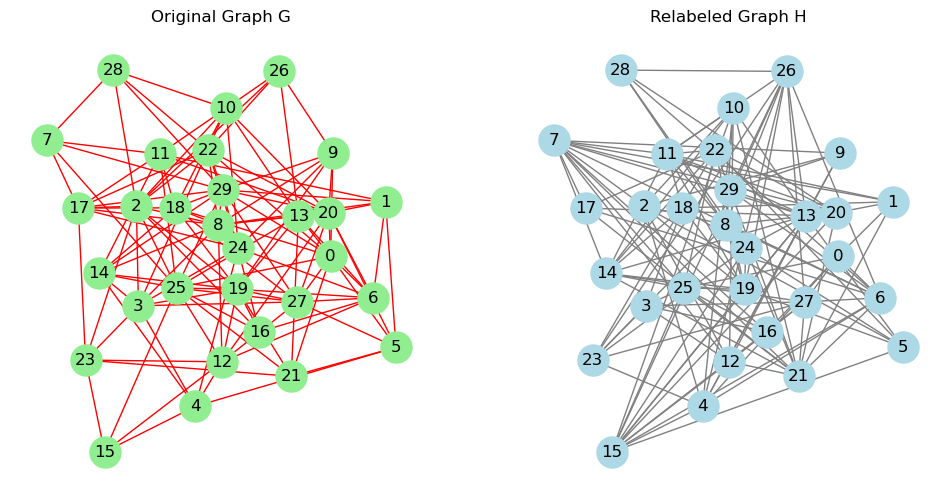

In [718]:
#G_0 = nx.karate_club_graph()
#for u, v in G_0.edges:
#    G_0[u][v].clear()
alpha = 0.005 ; beta = 0.3
#tpr = 0. ; fpr = 0.1
#G= generate_noisy_networks(G_0, alpha, beta, 1)[0]
#G = generate_noisy_networks(G_0, tpr, fpr, 1)[0]
#G = random_isomorphism(G_0)
#G_0, G = generate_correlated_graphs(30, 0.3, 0.9)
n = 30 ; q = 0.3 ; s = 1
G_0, G, pi_star = plant(n, q, s)


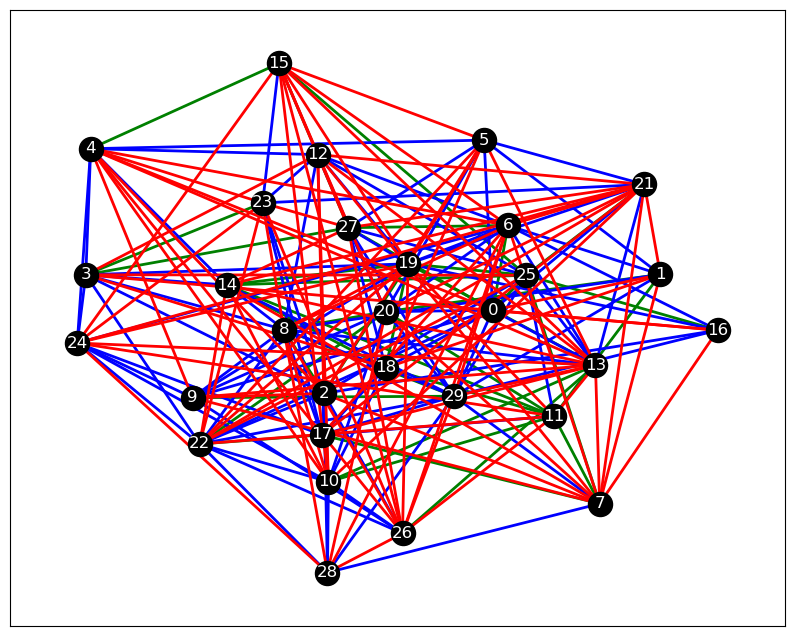

In [720]:
G1 = G_0  ; G2 = G
shared_edges = set(G1.edges()).intersection(set(G2.edges()))
G1_only_edges = set(G1.edges()) - shared_edges
G2_only_edges = set(G2.edges()) - shared_edges
pos = nx.spring_layout(G_0)
# Draw the graphs

plt.figure(figsize=(10, 8))

# Draw shared edges
nx.draw_networkx_edges(G1, pos, edgelist=shared_edges, edge_color='green', width=2, label='Shared Edges')

# Draw edges only in G1
nx.draw_networkx_edges(G1, pos, edgelist=G1_only_edges, edge_color='blue', width=2, label='Edges in G1 only')

# Draw edges only in G2
nx.draw_networkx_edges(G2, pos, edgelist=G2_only_edges, edge_color='red', width=2, label='Edges in G2 only')

# Draw nodes
nx.draw_networkx_nodes(G1, pos, node_color='black', node_size=300)
nx.draw_networkx_labels(G1, pos, font_color='white')
plt.show()

In [722]:
nx.is_isomorphic(G_0, G)

True

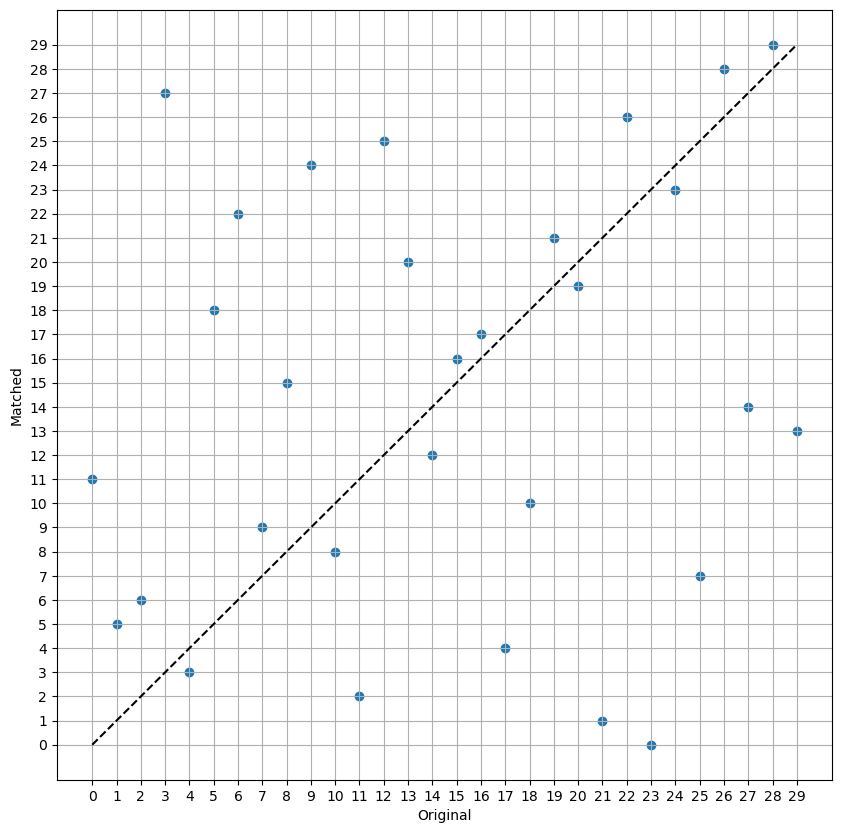

In [724]:
row1, col1 = optimal_solution1(G_0, G)
visualise_matching(G_0, G, row1, col1, plot_orbits=True)

row2, col2 = optimal_solution2(G_0, G)
#visualise_matching(G_0, G, row1, col1, plot_orbits=True)

In [726]:
metric = 'manhattan'
embedding1 = generate_embedding(G_0, M=1000)
embedding2 = generate_embedding(G, M=1000)

#embedding1 = mean_variance_embedding(G_0)
#embedding2 = mean_variance_embedding(G)

Computing FRT Distributions: 100%|██████████████| 30/30 [00:00<00:00, 72.02it/s]


In [727]:
row, col, _ = hungarian_matching(embedding1, embedding2, metric=metric)

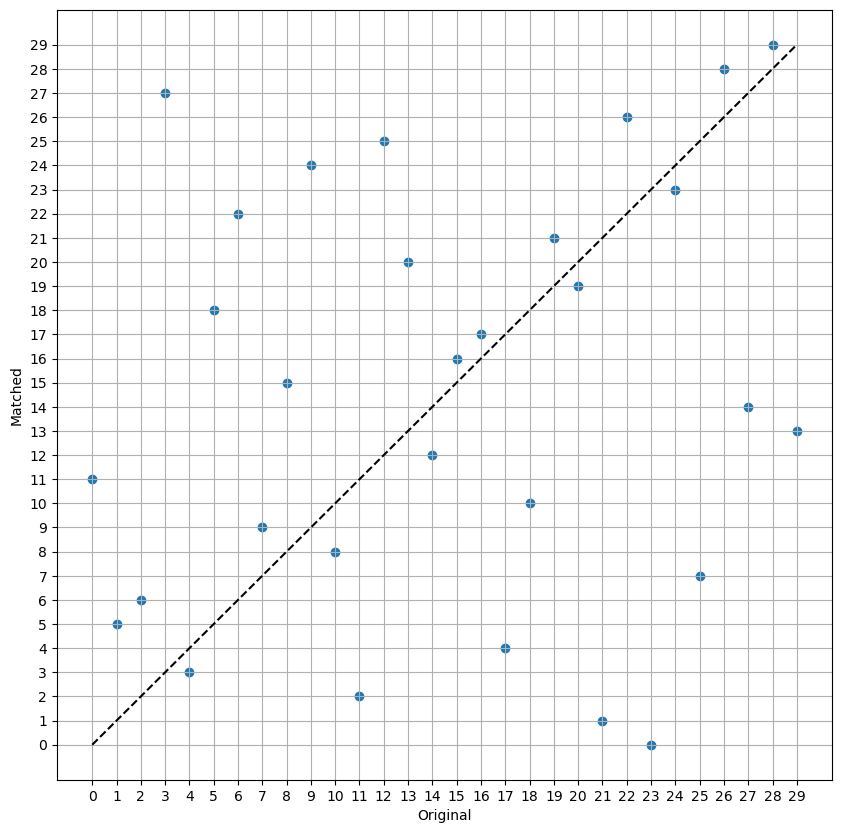

In [730]:
visualise_matching(G_0, G, row, col, plot_orbits=True)

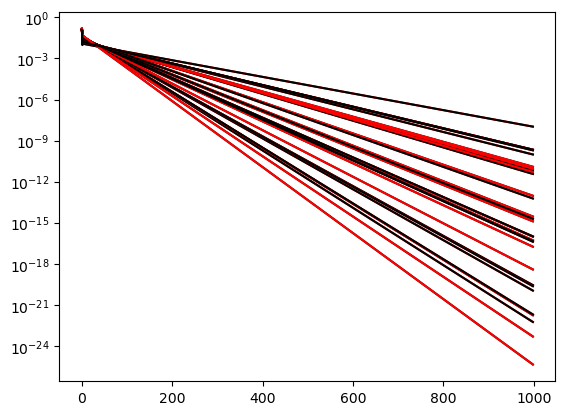

In [732]:
for i in range(len(G.nodes)):
    plt.plot(embedding1[i, :], color='r')
    plt.plot(embedding2[i, :], color='k')


plt.yscale('log')

In [734]:
print(compute_overlap(list(row1), list(col1), pi_star))

1.0


In [736]:
print(compute_overlap(list(row2), list(col2), pi_star))

0.13333333333333333


In [738]:
print(compute_overlap(row, col, pi_star))

1.0


In [740]:
matcher = nx.algorithms.isomorphism.GraphMatcher(G, G_0)

In [742]:
pi_star

array([11,  5,  6, 27,  3, 18, 22,  9, 15, 24,  8,  2, 25, 20, 12, 16, 17,
        4, 10, 21, 19,  1, 26,  0, 23,  7, 28, 14, 29, 13])

In [744]:
col

array([11,  5,  6, 27,  3, 18, 22,  9, 15, 24,  8,  2, 25, 20, 12, 16, 17,
        4, 10, 21, 19,  1, 26,  0, 23,  7, 28, 14, 29, 13])

In [746]:
col1

array([11,  5,  6, 27,  3, 18, 22,  9, 15, 24,  8,  2, 25, 20, 12, 16, 17,
        4, 10, 21, 19,  1, 26,  0, 23,  7, 28, 14, 29, 13])

In [748]:
[matching for matching in matcher.isomorphisms_iter()]

[{11: 0,
  18: 5,
  5: 1,
  3: 4,
  27: 3,
  6: 2,
  22: 6,
  15: 8,
  24: 9,
  8: 10,
  2: 11,
  9: 7,
  25: 12,
  20: 13,
  12: 14,
  16: 15,
  17: 16,
  4: 17,
  10: 18,
  21: 19,
  19: 20,
  1: 21,
  26: 22,
  0: 23,
  23: 24,
  7: 25,
  28: 26,
  14: 27,
  29: 28,
  13: 29}]

In [828]:
n = 30 ; q = 0.3 ; s = 0.9
print(n*q*s)
print(np.log(n))

8.1
3.4011973816621555


In [840]:
overlaps1 = np.zeros((11, 100)) ; overlaps = np.zeros((11, 100)) ; nqs = []
for s in tqdm(range(0, 11)):
    nqs.append(n*q*s/10)
    for i in range(100):
        overlaps1[s, i], overlaps[s, i] = find_overlap(n, q, s/10)

  0%|                                                    | 0/11 [00:00<?, ?it/s]/Users/vedantat/Desktop/DPhil Codes/frt_distributions.py:62: RuntimeWarning: divide by zero encountered in divide
  T = sp.diags(1 / D) @ A
100%|██████████████████████████████████████████| 11/11 [29:14<00:00, 159.51s/it]


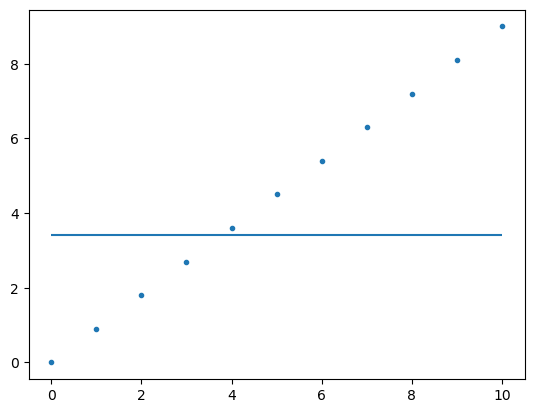

In [854]:
plt.plot(nqs, '.')
plt.hlines(np.log(n), 0, 10)

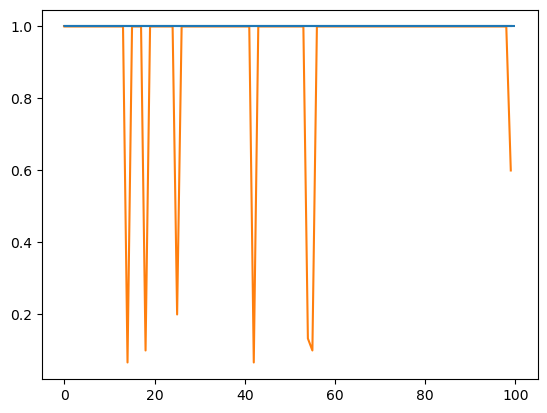

In [872]:
plt.plot(overlaps[10, :])
plt.plot(overlaps1[10, :])

plt.hlines(1, 0, 100)
#plt.plot(overlaps2)

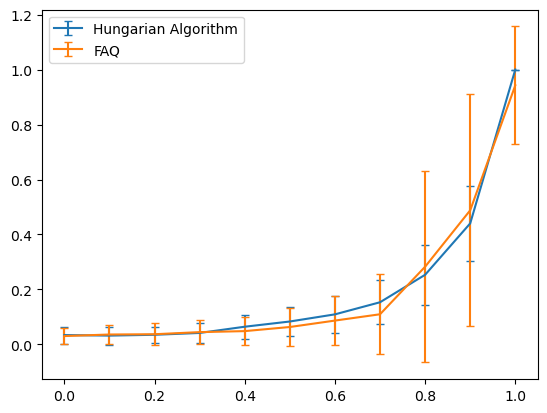

In [896]:
means = np.mean(overlaps, axis=1) ; stds = np.std(overlaps, axis=1)
means1 = np.mean(overlaps1, axis=1) ; stds1 = np.std(overlaps1, axis=1)

plt.errorbar(np.arange(0, 1.1, 0.1), means, yerr=stds, capsize=3, label='Hungarian Algorithm')
plt.errorbar(np.arange(0, 1.1, 0.1), means1, yerr=stds1, capsize=3, label='FAQ')
plt.legend()